In [2]:
import sys, os
from nn.wandb_classification_callback import WandbClassificationCallback


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # tensorflow を読み込む前のタイミングですると効果あり
import tensorflow as tf

tf.random.set_seed(100)
from data_analysis.utils import Utils
import sys
import datetime
import wandb
from wandb.keras import WandbCallback
from pre_process.pre_process import PreProcess
from nn.model_base import EDLModelBase, edl_classifier_1d
from nn.losses import EDLLoss
from pre_process.json_base import JsonBase
from data_analysis.py_color import PyColor
from collections import Counter
from nn.utils import load_model, separate_unc_data
from mywandb.utils import make_ss_dict4wandb
# 環境設定
CALC_DEVICE = "gpu"
# CALC_DEVICE = "cpu"
DEVICE_ID = "0" if CALC_DEVICE == "gpu" else "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE_ID
if os.environ["CUDA_VISIBLE_DEVICES"] != "-1":
    tf.keras.backend.set_floatx("float32")
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    # tf.config.run_functions_eagerly(True)
else:
    print("*** cpuで計算します ***")
    # なんか下のやつ使えなくなっている、、
    # tf.config.run_functions_eagerly(True)

In [3]:
TEST_RUN = False
HAS_ATTENTION = True
PSE_DATA = False
HAS_INCEPTION = True
IS_PREVIOUS = False
IS_NORMAL = True
IS_ENN = True  # FIXME: always true so remove here
IS_MUL_LAYER = False
CATCH_NREM2 = True
EPOCHS = 200
BATCH_SIZE = 16
N_CLASS = 5
KERNEL_SIZE = 512
STRIDE = 480
SAMPLE_SIZE = 40000
UNC_THRETHOLD = 0.5
DATA_TYPE = "spectrum"
FIT_POS = "middle"
EXPERIMENT_TYPES = (
    "no_cleansing",
    "positive_cleansing",
    "negative_cleansing",
)
EXPERIENT_TYPE = "positive_cleansing"
NORMAL_TAG = "normal" if IS_NORMAL else "sas"
ATTENTION_TAG = "attention" if HAS_ATTENTION else "no-attention"
PSE_DATA_TAG = "psedata" if PSE_DATA else "sleepdata"
INCEPTION_TAG = "inception" if HAS_INCEPTION else "no-inception"
WANDB_PROJECT = "test" if TEST_RUN else "enn4fixed_stride_fixed_sample"
ENN_TAG = "enn" if IS_ENN else "dnn"
INCEPTION_TAG += "v2" if IS_MUL_LAYER else ""
CATCH_NREM2_TAG = "catch_nrem2" if CATCH_NREM2 else "catch_nrem34"

In [7]:
# モデルの読み込み
loaded_name = "140703_Li"
date_id = {"nothing":"20211010-150603", "negative":"20211010-150603", "positive":"20211010-150603"}
n_class = 5
model = load_model(loaded_name=loaded_name, model_id=date_id, n_class=n_class, verbose=0)
# model.summary()

In [8]:
# Recordオブジェクトの読み込み
pre_process = PreProcess(
    data_type=DATA_TYPE,
    fit_pos=FIT_POS,
    verbose=0,
    kernel_size=KERNEL_SIZE,
    is_previous=IS_PREVIOUS,
    stride=STRIDE,
    is_normal=IS_NORMAL,
    has_nrem2_bias=True
)
datasets = pre_process.load_sleep_data.load_data(
    load_all=True, pse_data=PSE_DATA
)
utils = Utils(catch_nrem2=CATCH_NREM2)

*** すべての被験者を読み込みます（load_dataの引数:nameは無視します） ***
 /home/takadamalab/taiki_senju/sleep_study/datas/pre_processed_data/spectrum/middle/140703_Li_.savが存在しません 


SystemExit: 3

In [5]:
# 訓練データとテストデータの分類
(train, test) = pre_process.split_train_test_from_records(
    datasets, test_id=0, pse_data=PSE_DATA 
)
(x_train, y_train), (x_test, y_test) = pre_process.make_dataset(
    train=train,
    test=test,
    is_storchastic=False,
    pse_data=PSE_DATA,
    to_one_hot_vector=False,
    each_data_size=SAMPLE_SIZE,
    is_shuffle=False

)

- 訓練データのサイズを揃えます
訓練データの各睡眠段階（補正前） Counter({2.0: 27314, None: 25702, 4.0: 11432, 5.0: 8764, 3.0: 6753, 1: 1872, 0: 64})
訓練データの各睡眠段階（補正後） {1: 40000, 2: 80000, 3: 40000, 4: 40000, 5: 40000}


/home/takadamalab/taiki_senju/git/sleep_study/pre_process/pre_process.py:273: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([data.spectrum for data in list_data])


- noneの処理を行います
- max正規化を行います
- チャンネル方向に軸を追加します
*** 全ての前処理後（one-hotを除く）の訓練データセット（確認用） *** 
 Counter({1: 80000, 0: 40000, 2: 40000, 3: 40000, 4: 40000})


In [6]:
# データを各睡眠段階ごとに分類する
x_train_nr34 = x_train[:40000]
y_test_nr34 = y_test[:40000]
x_train_nr2 = x_train[40000:120000]
y_test_nr2 = y_test[40000:120000]
x_train_nr1 = x_train[120000:160000]
y_test_nr1 = y_test[120000:160000]
x_train_rem = x_train[160000:200000]
y_test_rem = y_test[160000:200000]
x_train_wake = x_train[200000:]
y_test_wake = y_test[200000:]

In [14]:
# モデルのアテンションを抽出
model.layers[-7].output
new_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-7].output)

In [55]:
att_nr1 = new_model.predict(x_train_nr34)

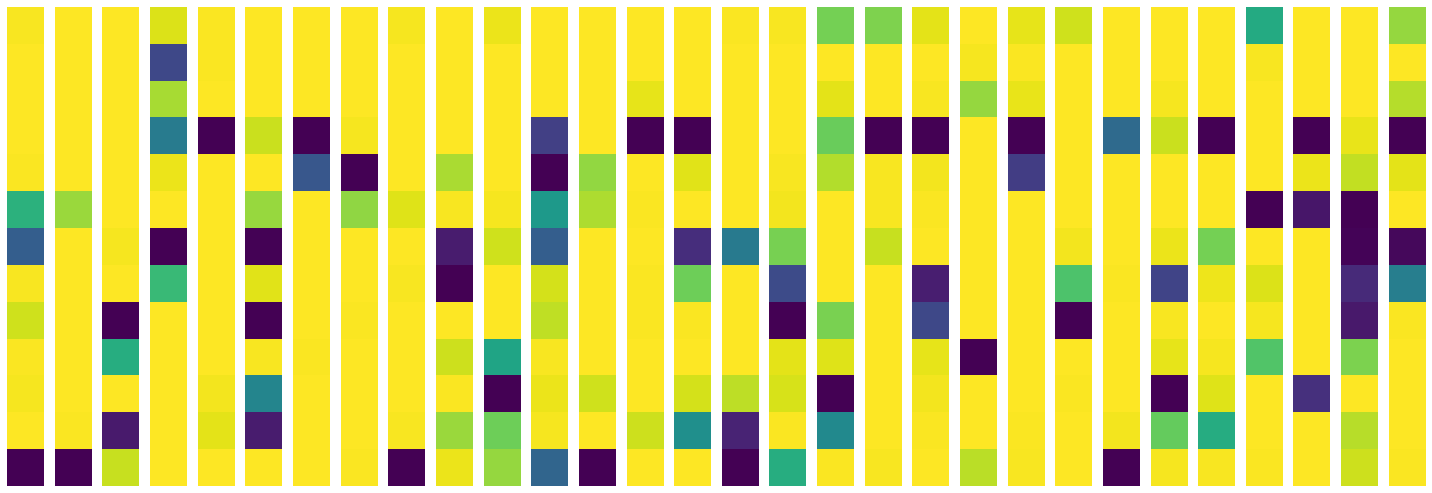

In [56]:
# 可視化
import matplotlib.pyplot as plt
%matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(111)
fig, axes = plt.subplots(1, 30, figsize=(20, 20))
axes = axes.flatten()
for img, ax in zip(att_nr1, axes):
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
# im = ax.imshow(att_nr1[4])
# cbar = fig.colorbar(im)
plt.savefig("attention.png")

In [126]:
# 主成分分析をやってみる
import numpy as np
from sklearn.decomposition import PCA
# x_train_nr1 = np.reshape(x_train_nr1, (-1, 256))
# x_train_nr2 = np.reshape(x_train_nr2, (-1, 256))
# 第2主成分までをプロット
# pca = PCA(n_components=2)
x_test4pca = np.reshape(x_test, (-1, 256))
pca = PCA()
pca.fit(x_test4pca)
feature_test = pca.transform(x_test4pca)
# feature_nr2 = pca.fit(x_train_nr2)
# feature_nr2 = pca.transform(x_train_nr2)


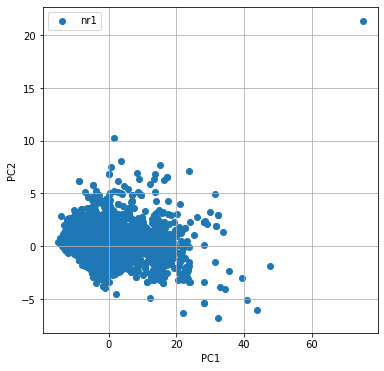

In [116]:
#第2主成分まででプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(feature_nr1[::10, 0], feature_nr1[::10, 1], label="nr1")
# plt.scatter(feature_nr2[::100, 0], feature_nr2[::100, 1], label="nr2")
plt.grid()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("tmp.png")

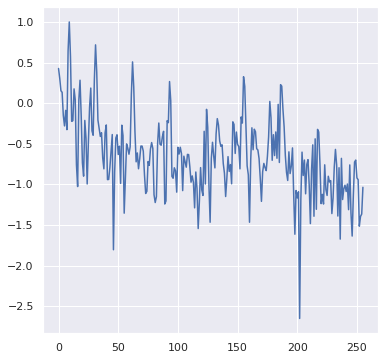

In [249]:
# スペクトルをプロット
plt.figure(figsize=(6, 6))
plt.plot(x_train[5])
plt.savefig("tmp.png")

In [92]:
# 主成分
print(pca.components_.shape)
# 平均
print(pca.mean_.shape)
# 分散
print(pca.get_covariance().shape)

(2, 256)
(256,)
(256, 256)


In [98]:
pca.get_covariance()[1]

-0.00817312815159649

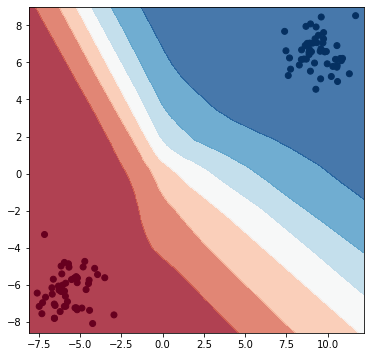

In [109]:
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

if __name__ == "__main__":

    # サンプルデータを生成する
    x, y = make_blobs(n_samples=100, n_features=2, centers=2)

    # 分類モデル（※今回はニューラルネットワーク）を作成する
    estimator = MLPClassifier()
    estimator.fit(x, y)

    # サンプルデータの値域を求める
    f1_min = x[:, 0].min() - 0.5
    f1_max = x[:, 0].max() + 0.5
    f2_min = x[:, 1].min() - 0.5
    f2_max = x[:, 1].max() + 0.5

    step = 0.02
    f1_range = np.arange(f1_min, f1_max, step)
    f2_range = np.arange(f2_min, f2_max, step)
    f1, f2 = np.meshgrid(f1_range, f2_range)

    # 決定境界を描画する
    Z = estimator.predict_proba(np.c_[f1.ravel(), f2.ravel()])[:, 1]
    Z = Z.reshape(f1.shape)
    plt.figure(figsize=(6, 6))
    plt.contourf(f1, f2, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.RdBu)
    plt.show()

In [105]:
f1.shape

(470, 408)

In [106]:
f2.shape

(470, 408)

In [155]:
# ENNを用いた予測
evidence = model.predict(x_test)
alpha = evidence + 1
y_pred = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)
y_pred = np.argmax(y_pred, axis=1)
unc = 5 / tf.reduce_sum(alpha, axis=1, keepdims=True).numpy()

In [156]:
unc.shape

(913, 1)

In [158]:
# データフレームへの書き出し
import pandas as pd
spectrum = [f"dim_{i}" for i in range(256)]
# class = ["class"]
# 主成分（固有ベクトル）
# pca.components_.shape
# くっつけるためにreshape
y_test4table = y_test.reshape(-1, 1)
y_pred4table = y_pred.reshape(-1, 1)
table = np.hstack([y_test4table, y_pred4table, unc, feature_test])
header = ["y_true"] + ["y_pred"] + ["unc"] + spectrum
table_with_header = np.vstack([header, table])
# データフレームへの出力（CSVではないよ）
df = pd.DataFrame(table_with_header)
df.to_csv("tmp.csv")

No handles with labels found to put in legend.


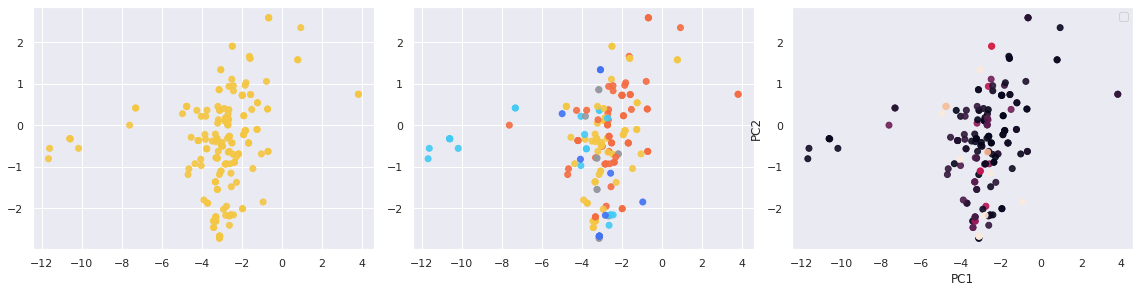

In [290]:
#第2主成分まででプロット
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
x_axis = 0
y_axis = 1
stride = 1
# nrem1
# stop = 41
# nrem2
start = 41
# stop = 462
# nrem34
# start = 464
stop = 626
# wake
start = 628
stop = 738
# rem
start = 739
stop = 914
ss_color = ["#4372f4", "#f46d43", "#9799a0", "#f4c643", "#43caf4"]
y_test4ss = [ss_color[int(id)] for id in y_test]
y_pred4ss = [ss_color[int(id)] for id in y_pred]
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(feature_test[start:stop:stride, x_axis], feature_test[start:stop:stride, y_axis], alpha=0.9, c=y_test4ss[start:stop:stride])
ax = fig.add_subplot(1, 3, 2)
ax.scatter(feature_test[start:stop:stride, x_axis], feature_test[start:stop:stride, y_axis], alpha=0.9, c=y_pred4ss[start:stop:stride])
ax = fig.add_subplot(1, 3, 3)
ax.scatter(feature_test[start:stop:stride, x_axis], feature_test[start:stop:stride, y_axis], alpha=0.9, c=unc[start:stop:stride])
plt.tight_layout()
# plt.colorbar()
# cbar = fig.colorbar(y_test)
# plt.scatter(feature_nr2[::100, 0], feature_nr2[::100, 1], label="nr2")
plt.grid()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("3pict.png")
# plt.show()

In [279]:
tmp = np.dot(x_train[0].T, x_train[0])
tmp

array([[110.49582606]])

In [280]:
tf.reduce_sum(np.abs(x_train[0]), axis=0)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([151.22139406])>

In [103]:
# 2クラス分類の結果をマージする
import numpy as np
import pandas as pd
import sys, os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
filedir = os.path.join(os.environ["sleep"], "log", "bin_merge", "*.csv")

In [11]:
filelist = glob(filedir)

In [12]:
filelist[0]

'/home/takadamalab/taiki_senju/sleep_study/log/bin_merge/output_3_yamane_202007.csv'

In [13]:
# tmp
df = pd.read_csv(filelist[0])

In [14]:
acc_num = sum(df["11"] == df["12"])
row, _ = df.shape

KeyError: '11'

In [84]:
# 統合ルールA
# 0. フラグが一本立っている場合はそれ
# 1. フラグが複数立っている場合一番不確実性の一番低いものを採用する
# 2. フラグが何も立っていない場合はNR2と判断する
def merge_rule_a(df):
    y_pred = list()
    table = df.to_numpy()
    for row in table:
        # flagの立っている一の情報を保持
        flag = row[1:6]
        if int(sum(flag)) == 1:
            y_pred.append(np.argmax(flag))
            continue
        elif int(sum(flag)) > 1:
            flag_unc = row[6:11]
            # フラグが立っている場所だけ残す
            flag_unc = flag_unc * flag
            # 不確実性が最小の睡眠段階を抽出する
#             print(flag_unc == np.min(flag_unc[np.nonzero(flag)]))
#             print(np.argmax(flag_unc == np.min(flag_unc[np.nonzero(flag)])))
            y_pred.append(np.argmax(flag_unc == np.min(flag_unc[np.nonzero(flag)])))
            continue
        else:
            assert int(sum(flag)) == 0
            # NR2を返す
            y_pred.append(1)
    return y_pred

# 統合ルールB
# 0. ひとつだけPositiveならそのクラス
# 1. NR2, remがPositiveならrem
# 2. nr1, wakeがpositiveならwake
# 3. positiveのなかで優先度の高いもので並び替え
# 4. nr2
def merge_rule_b(df):
    y_pred = list()
    table = df.to_numpy()
    for row in table:
        # 0. ひとつだけPositiveならそのクラス
        flag = row[1:6]
        if int(sum(flag)) == 1:
            y_pred.append(np.argmax(flag))

        # 1. NR2, remがPositiveならrem
        elif row[2] == 1 and row[4] == 1:
            y_pred.append(3)

        # 2. nr1, wakeがpositiveならwake
        elif row[3] == 1 and row[5] == 1:
            y_pred.append(4)

        # 3. positiveのなかで優先度の高いもので並び替え
        elif int(sum(flag)) > 1:
            flag_unc = row[6:11]
            # フラグが立っている場所だけ残す
            flag_unc = flag_unc * flag
            # 不確実性が最小の睡眠段階を抽出する
#             print(flag_unc == np.min(flag_unc[np.nonzero(flag)]))
#             print(np.argmax(flag_unc == np.min(flag_unc[np.nonzero(flag)])))
            y_pred.append(np.argmax(flag_unc == np.min(flag_unc[np.nonzero(flag)])))

        # 4. nr2
        else:
            assert int(sum(flag)) == 0
            # NR2を返す
            y_pred.append(1)
    return y_pred

def calc_acc(df):
    def __judge_acc_from_column_id(l):
        return sum(df[str(l[0])] == df[str(l[1])])
    acc_list = list(map(__judge_acc_from_column_id, [[11, 12], [11, 13]]))
    print("統合ルールA, Bの正解数", acc_list)
    row, _ = df.shape
    return [_acc_list / row for _acc_list in acc_list]

In [57]:
# __tmp = np.array([merge_rule_a(df), merge_rule_b(df)])
# __row = df.shape[0]
# try:
#     assert __tmp.shape == (__row, 2)
# except:
#     print(__tmp.T.shape)

(817, 2)


In [74]:
filedir = os.path.join(os.environ["sleep"], "log", "bin_merge", "*.csv")
filelist = glob(filedir)
for filepath in filelist:
    _, filename = os.path.split(filepath)
    df = pd.read_csv(filepath)
    y_pred = np.array([merge_rule_a(df), merge_rule_b(df)]).T   #reshape(-1, 2)
    new_df = pd.DataFrame(np.hstack([df.to_numpy(), y_pred]))
    output_path = os.path.join(os.environ["sleep"], "log", "bin_merge_ver2")
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    new_df.to_csv(os.path.join(output_path, filename))

In [85]:
filelist = os.path.join(os.environ["sleep"], "log", "bin_merge_ver2", "*.csv")
filelist = glob(filelist)
acc_list = list()
for filepath in filelist:
    df = pd.read_csv(filepath)
    acc_list.append(calc_acc(df))

統合ルールA, Bの正解数 [394, 420]
統合ルールA, Bの正解数 [395, 400]
統合ルールA, Bの正解数 [189, 172]
統合ルールA, Bの正解数 [510, 501]
統合ルールA, Bの正解数 [420, 430]
統合ルールA, Bの正解数 [108, 115]
統合ルールA, Bの正解数 [306, 299]
統合ルールA, Bの正解数 [325, 203]
統合ルールA, Bの正解数 [409, 396]
統合ルールA, Bの正解数 [190, 153]
統合ルールA, Bの正解数 [333, 323]
統合ルールA, Bの正解数 [445, 436]
統合ルールA, Bの正解数 [423, 410]
統合ルールA, Bの正解数 [398, 377]
統合ルールA, Bの正解数 [333, 75]
統合ルールA, Bの正解数 [308, 299]
統合ルールA, Bの正解数 [320, 303]
統合ルールA, Bの正解数 [338, 337]
統合ルールA, Bの正解数 [318, 270]
統合ルールA, Bの正解数 [175, 164]
統合ルールA, Bの正解数 [464, 386]
統合ルールA, Bの正解数 [182, 194]
統合ルールA, Bの正解数 [291, 271]
統合ルールA, Bの正解数 [99, 88]
統合ルールA, Bの正解数 [300, 291]
統合ルールA, Bの正解数 [85, 79]
統合ルールA, Bの正解数 [340, 320]
統合ルールA, Bの正解数 [275, 274]
統合ルールA, Bの正解数 [142, 137]
統合ルールA, Bの正解数 [396, 398]
統合ルールA, Bの正解数 [280, 210]
統合ルールA, Bの正解数 [169, 174]
統合ルールA, Bの正解数 [255, 267]
統合ルールA, Bの正解数 [365, 368]
統合ルールA, Bの正解数 [526, 477]
統合ルールA, Bの正解数 [172, 167]
統合ルールA, Bの正解数 [221, 218]
統合ルールA, Bの正解数 [547, 528]
統合ルールA, Bの正解数 [176, 166]
統合ルールA, Bの正解数 [162, 175]
統合ルール

In [86]:
max(acc_list)

[0.631236442516269, 0.5878524945770065]

In [109]:
np.median(acc_list, axis=0)

array([0.35580524, 0.34624146])

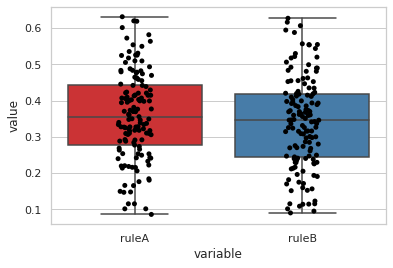

In [115]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')
# DataFrameに変換
df = pd.DataFrame(acc_list, columns=("ruleA", "ruleB"))
# 各行にruleA or ruleBを表示するように変換
df_melt = pd.melt(df)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False, ax=ax)
sns.stripplot(x='variable', y='value', data=df_melt, jitter=True, color='black', ax=ax)
# plt.show()
plt.savefig(os.path.join(os.environ["sleep"], "figures", "tmp", "boxplot.png"))

In [101]:
df = pd.DataFrame(acc_list, columns=("ruleA", "ruleB"))
df

,ruleA,ruleB
0,0.349291,0.372340
1,0.483476,0.489596
2,0.327556,0.298094
3,0.563536,0.553591
4,0.478360,0.489749
...,...,...
132,0.115496,0.115496
133,0.309594,0.369931
134,0.291391,0.297067
135,0.421466,0.422775


In [100]:
pd.melt(df)

,variable,value
0,ruleA,0.349291
1,ruleA,0.483476
2,ruleA,0.327556
3,ruleA,0.563536
4,ruleA,0.478360
...,...,...
269,ruleB,0.115496
270,ruleB,0.369931
271,ruleB,0.297067
272,ruleB,0.422775


In [160]:
filedir = os.path.join(os.environ["sleep"], "log", "bin_merge_ver2")

In [161]:
y_pred_merged = np.array(merge_rule_a(df)).reshape(-1, 1)

In [162]:
df.to_numpy().shape
y_pred_merged.reshape(-1, 1)

array([[4],
       [4],
       [4],
       [4],
       [4],
       [2],
       [4],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [4],
       [4],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [2],
       [3],
       [3],
       [0],
       [3],
       [3],
       [3],
       [4],
       [4],
       [3],
       [3],
       [2],
       [3],
       [3],
       [3],
       [3],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [4],
       [1],
       [3],
       [3],
       [4],
       [4],
       [4],
       [4],
       [3],
       [3],
       [3],
       [3],
       [3],
       [4],
       [2],
       [3],
       [2],
       [4],
       [4],
       [4],
       [4],
       [4],
       [3],
       [3],
       [3],
    

In [91]:
pd.DataFrame(np.hstack([df.to_numpy(), y_pred_merged]))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.0,1.0,1.0,1.0,0.108909,0.280165,1.000000,1.0,0.104631,3.0,4.0
1,1.0,0.0,0.0,1.0,1.0,1.0,0.130123,0.269364,1.000000,1.0,0.126029,3.0,4.0
2,2.0,0.0,0.0,1.0,1.0,1.0,0.146472,0.270092,1.000000,1.0,0.138124,3.0,4.0
3,3.0,0.0,0.0,1.0,1.0,1.0,0.138603,0.279362,1.000000,1.0,0.150066,3.0,4.0
4,4.0,0.0,0.0,1.0,1.0,1.0,0.142555,0.281552,1.000000,1.0,0.143203,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1123.0,0.0,0.0,0.0,1.0,0.0,0.284844,0.271687,0.040096,1.0,0.143482,2.0,3.0
1124,1124.0,1.0,0.0,0.0,1.0,1.0,0.285358,0.233409,0.039761,1.0,0.216516,1.0,4.0
1125,1125.0,1.0,0.0,0.0,1.0,1.0,0.200948,0.291424,0.028916,1.0,0.207295,4.0,0.0
1126,1126.0,1.0,0.0,0.0,1.0,1.0,0.220612,0.315200,0.037461,1.0,0.110232,4.0,4.0


In [77]:
pd.concat([df, y_pred_merged])

,0,0,1,10,2,3,4,5,6,7,8,9,Unnamed: 0
0,NaN,0.0,0.0,3.0,1.0,1.0,1.0,0.108909,0.280165,1.0,1.0,0.104631,0.0
1,NaN,0.0,0.0,3.0,1.0,1.0,1.0,0.130123,0.269364,1.0,1.0,0.126029,1.0
2,NaN,0.0,0.0,3.0,1.0,1.0,1.0,0.146472,0.270092,1.0,1.0,0.138124,2.0
3,NaN,0.0,0.0,3.0,1.0,1.0,1.0,0.138603,0.279362,1.0,1.0,0.150066,3.0
4,NaN,0.0,0.0,3.0,1.0,1.0,1.0,0.142555,0.281552,1.0,1.0,0.143203,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1124,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1125,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1126,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,0,0.0,0.0,1.0,1.0,1.0,0.108909,0.280165,1.0,1.0,0.104631,3.0
1,1,0.0,0.0,1.0,1.0,1.0,0.130123,0.269364,1.0,1.0,0.126029,3.0
2,2,0.0,0.0,1.0,1.0,1.0,0.146472,0.270092,1.0,1.0,0.138124,3.0
3,3,0.0,0.0,1.0,1.0,1.0,0.138603,0.279362,1.0,1.0,0.150066,3.0
4,4,0.0,0.0,1.0,1.0,1.0,0.142555,0.281552,1.0,1.0,0.143203,3.0


In [49]:
df_np[1][1:6]

array([0., 0., 1., 1., 1.])

In [30]:
df_np = df.to_numpy()

In [33]:
df_np[1]

array([1.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.13012268, 0.26936367, 1.        , 1.        ,
       0.12602893, 3.        ])

In [34]:
df_np.shape

(1128, 12)

In [38]:
np.argmax(df_np[1][1:6])

2

In [42]:
flag = df_np[1][1:6]
flag_unc = df_np[1][6:11]

In [43]:
flag

array([0., 0., 1., 1., 1.])

In [44]:
flag_unc

array([0.13012268, 0.26936367, 1.        , 1.        , 0.12602893])

In [45]:
flag*flag_unc

array([0.        , 0.        , 1.        , 1.        , 0.12602893])

In [50]:
np.nonzero(flag*flag_unc)

(array([2, 3, 4]),)

In [51]:
np.min(np.nonzero(flag*flag_unc))

2

In [147]:
sorted(acc_list)

[0.09034907597535935,
 0.09533468559837728,
 0.11462450592885376,
 0.11549566891241578,
 0.12307692307692308,
 0.15162454873646208,
 0.1566757493188011,
 0.15985997666277713,
 0.1701346389228886,
 0.17145790554414783,
 0.1750841750841751,
 0.18193069306930693,
 0.19085173501577288,
 0.19375,
 0.19636678200692043,
 0.20539730134932535,
 0.2116704805491991,
 0.21641791044776118,
 0.22559652928416485,
 0.22755741127348644,
 0.2292817679558011,
 0.22982885085574573,
 0.22985781990521326,
 0.23979591836734693,
 0.24053452115812918,
 0.2413793103448276,
 0.24476190476190476,
 0.2469879518072289,
 0.2471264367816092,
 0.24964336661911554,
 0.26147278548559233,
 0.2682080924855491,
 0.2702702702702703,
 0.2801418439716312,
 0.285,
 0.28651685393258425,
 0.29706717123935666,
 0.29809358752166376,
 0.3002283105022831,
 0.30798845043310874,
 0.3153153153153153,
 0.31573389651531153,
 0.31620553359683795,
 0.3162291169451074,
 0.3265097236438076,
 0.33619763694951665,
 0.34133611691022964,
 0.3423